In [54]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

In [55]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [56]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### **Проведем преобразование данных для обучения**

In [57]:
train_id = train['Id']
test_id = test['Id']
train = train.drop(['Id'], axis=1)
test = test.drop(['Id'], axis=1)

In [58]:
train.shape

(1460, 80)

In [59]:
test.shape

(1459, 79)

In [60]:
train.corrwith(train['SalePrice']).abs().sort_values()[::-1]

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
dtype: float64

In [61]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [62]:
ntrain = train.shape[0]
ntest = test.shape[0]

In [63]:
train_prices = train.SalePrice.values
train["SalePrice"] = np.log1p(train["SalePrice"])
y_train = train.SalePrice.values

In [64]:
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [65]:
total_missings=missing_data(all_data)
total_missings.head(15)

,Total,Percent
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageCond,159,5.447071
GarageQual,159,5.447071
GarageYrBlt,159,5.447071
GarageFinish,159,5.447071


In [66]:
#уберем фичи, в которых больше 80% пропущенных данных
all_data = all_data.drop((total_missings[total_missings['Percent'] > 80]).index,1) 

In [67]:
#закодируем категориальные фичи
all_data = pd.get_dummies(all_data)  

In [68]:
numeric = all_data.select_dtypes(exclude = ["object"]).columns
categorical = all_data.select_dtypes(include = ["object"]).columns

In [69]:
#заполним пропуски данных
missings = [] 

for i in categorical:
  missings.append(all_data[i].value_counts().idxmax())

for i in range(len(categorical)):
    all_data[categorical[i]].fillna(missings[i], inplace=True)

for i in numeric:
    all_data[i].fillna(all_data[i].median(), inplace=True)

In [70]:
train = all_data[:ntrain]
test = all_data[ntrain:]

### **Обучение модели**
В качестве признаков были выбраны наиболее информативные (признаки, содержащие более 80% пропусков информации были отброшены), так как при использовании одного или нескольких, коррелируемых с целевой переменной, признаков не удается получить более точного результата, чем при использовании всех преобразованных, неотсеянных признаков. 

In [71]:
kf = KFold(n_splits=5)
kf.get_n_splits(train)

5

In [72]:
print(kf)
rmse_list = []
for alpha in [0.001, 0.01, 0.1, 1, 10]:
  first_model = Lasso(alpha=alpha)
  for rand_state in [10,20,30,42,50]:
      X_train, X_test, y_train_tts, y_test_tts = train_test_split(train, y_train, test_size=0.25, random_state=rand_state)
      first_model.fit(X_train, y_train_tts)
      predict = first_model.predict(X_test)
      rmse = np.sqrt(mean_squared_error(predict,y_test_tts))
      rmse_list.append(rmse)
      
  print("Mean rmse for alpha={}: {}".format(alpha, str(np.mean(rmse_list))))
  print("std rmse for alpha={}: {}".format(alpha, str(np.std(rmse_list))))

KFold(n_splits=5, random_state=None, shuffle=False)
Mean rmse for alpha=0.001: 0.12420558054332989
std rmse for alpha=0.001: 0.006430745519092559
Mean rmse for alpha=0.01: 0.13326800181718412
std rmse for alpha=0.01: 0.010835708833893521
Mean rmse for alpha=0.1: 0.14594170768933673
std rmse for alpha=0.1: 0.02055315827742867
Mean rmse for alpha=1: 0.15482039602618175
std rmse for alpha=1: 0.02391747587022895
Mean rmse for alpha=10: 0.16854938704263986
std rmse for alpha=10: 0.03492794856798202


In [73]:
first_model = Lasso(alpha=0.001)
first_model.fit(train, y_train)
lasso_pred = first_model.predict(test)

In [74]:
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = np.exp(lasso_pred)
submission.to_csv('sub_test.csv',index=False)

In [75]:
df = pd.read_csv('sub_test.csv')
df.head(5)

,Id,SalePrice
0,1461,115987.839490
1,1462,139249.980300
2,1463,171020.300787
3,1464,200264.201783
4,1465,197228.497228


### **Построим модели с использованием разных методов**

In [76]:
#введем функцию для кросс-валидации
n_folds = 5
def validation_function(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [77]:
ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
print('ENet rmse score:{}'.format(validation_function(ENet).mean()))

ENet rmse score:0.13635629023611545


In [78]:
dtreg = DecisionTreeRegressor(random_state = 100, max_depth=7)
print('dtreg rmse score:{}'.format(validation_function(dtreg).mean()))

dtreg rmse score:0.18961537210599128


In [79]:
las = Lasso(alpha=0.001)
print('las rmse score:{}'.format(validation_function(las).mean()))

las rmse score:0.1386661482575626


In [80]:
ENet.fit(train, y_train)
ENet_pred = np.exp(ENet.predict(test))

In [81]:
dtreg.fit(train, y_train)
dtreg_pred = np.exp(dtreg.predict(test))

In [82]:
las.fit(train, y_train)
las_pred = np.exp(las.predict(test))

In [83]:
#используем среднее арифметическое построенных моделей для предсказания целевой переменной
total_score = (las_pred + ENet_pred + dtreg_pred)/3

In [84]:
submission_2 = pd.DataFrame()
submission_2['Id'] = test_id
submission_2['SalePrice'] = total_score
submission_2.to_csv('submission_for_total.csv',index=False)

### **Построим график зависимости метрик на лидерборде и на кросс-валидации**

Submission 1 - SGDRegressor с одной фичей

Submission 2 - LinearRegression с одной фичей

Submission 3 - SGDRegressor с набором фич

Submission 4 - ElasticNet, Lasso и DecisionTreeRegressor

Submission 5 - Lasso

In [85]:
validation_scores = [0.46558, 0.23588, 0.19973, 0.15487, 0.16855]

In [86]:
leaderboard_scores = [0.44443, 0.23289, 0.19833, 0.13641, 0.13303]

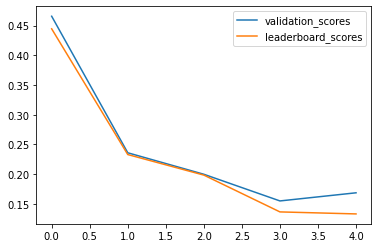

In [87]:
df = pd.DataFrame({'validation_scores': [0.46558, 0.23588, 0.19973, 0.15487, 0.16855],
                   'leaderboard_scores': [0.44443, 0.23289, 0.19833, 0.13641, 0.13303]})
df.plot()

Таким образом, скор на кросс-валидации несколько хуже, чем на лидерборде. Лучшего результата удалось добиться используя Lasso и наибольшее количество признаков